# START PROJEKTA

In [2]:
import duckdb

import mplsoccer
from mplsoccer import Pitch, VerticalPitch

import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px

## SPOZNAVANJE S PODATKI

### Players
Gre za zbirko 940 igralcev, kateri imajo naslednje **značilnice**:
 * player_id          940 non-null    int64         
 * short_name         940 non-null    object        
 * birth_date         940 non-null    datetime64[ns]
 * foot               936 non-null    object        
 * role               940 non-null    object        
 * passport           940 non-null    object        
 * index_level_0      940 non-null    int64


In [22]:
df_players = duckdb.sql(f"""SELECT * FROM 'data/players.parquet' """).df()
df_players

player_id        short_name birth_date   foot        role  \
0         8319         J. Milner 1986-01-04  right  Midfielder   
1        25572           A. Ayew 1989-12-17   left     Forward   
2        14870          J. Matip 1991-08-08  right    Defender   
3       214220           Alisson 1992-10-02  right  Goalkeeper   
4        83150         V. Coufal 1992-08-22  right    Defender   
..         ...               ...        ...    ...         ...   
935     645032  Youssef Chermiti 2004-05-24  right     Forward   
936     399489       H. Delcroix 1999-02-28   left    Defender   
937     120339    Mohamed Elneny 1992-07-11  right  Midfielder   
938     601883      F. Pellistri 2001-12-20  right  Midfielder   
939     669602        N. Jackson 2001-06-20  right     Forward   

           passport  __index_level_0__  
0           England                  0  
1             Ghana                  1  
2          Cameroon                  2  
3            Brazil                  3  
4    Czech Republic                  4  
..              ...                ...  
935         Tunisia                935  
936         Belgium                936  
937           Egypt                937  
938           Spain                938  
939         Senegal                939  

[940 rows x 7 columns]

In [4]:
df_players.describe()

player_id                     birth_date  __index_level_0__
count     940.000000                            940         940.000000
mean   334885.101064  1997-04-13 21:48:15.319148928         469.500000
min        47.000000            1981-09-28 00:00:00           0.000000
25%     70114.750000            1993-09-05 18:00:00         234.750000
50%    364426.500000            1997-07-07 12:00:00         469.500000
75%    528206.250000            2001-01-05 00:00:00         704.250000
max    901432.000000            2007-08-11 00:00:00         939.000000
std    235612.312184                            NaN         271.498926

In [5]:
df_players.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 940 entries, 0 to 939
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   player_id          940 non-null    int64         
 1   short_name         940 non-null    object        
 2   birth_date         940 non-null    datetime64[ns]
 3   foot               936 non-null    object        
 4   role               940 non-null    object        
 5   passport           940 non-null    object        
 6   __index_level_0__  940 non-null    int64         
dtypes: datetime64[ns](1), int64(2), object(4)
memory usage: 51.5+ KB


In [6]:
df_players.shape

(940, 7)

In [9]:
df_players.isnull().sum()

player_id            0
short_name           0
birth_date           0
foot                 4
role                 0
passport             0
__index_level_0__    0
dtype: int64

In [43]:
df_players['role'].value_counts()

role
Midfielder    318
Defender      304
Forward       245
Goalkeeper     73
Name: count, dtype: int64

In [3]:
country_counts = df_players['passport'].value_counts().reset_index()
country_counts.head(10)

passport  count
0           England    204
1             Spain     53
2           Nigeria     40
3  Ireland Republic     39
4            Brazil     37
5          Scotland     35
6          Portugal     33
7           Jamaica     33
8             Italy     26
9          Congo DR     23

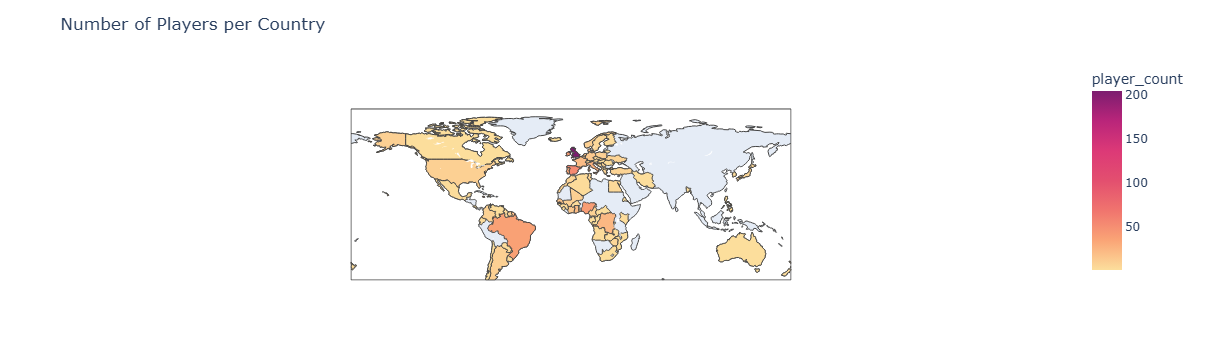

In [4]:
country_counts.columns = ['country', 'player_count']

country_counts['country'] = country_counts['country'].replace('England', 'United Kingdom') #da se lahko obarva na zemljevidu

fig = px.choropleth(country_counts,
                    locations='country',
                    locationmode='country names',
                    color='player_count',
                    hover_name='country',
                    hover_data=['player_count'],
                    #range_color=[0,50],
                    color_continuous_scale='sunsetdark')
fig.update_layout(title_text='Number of Players per Country')
fig.show()

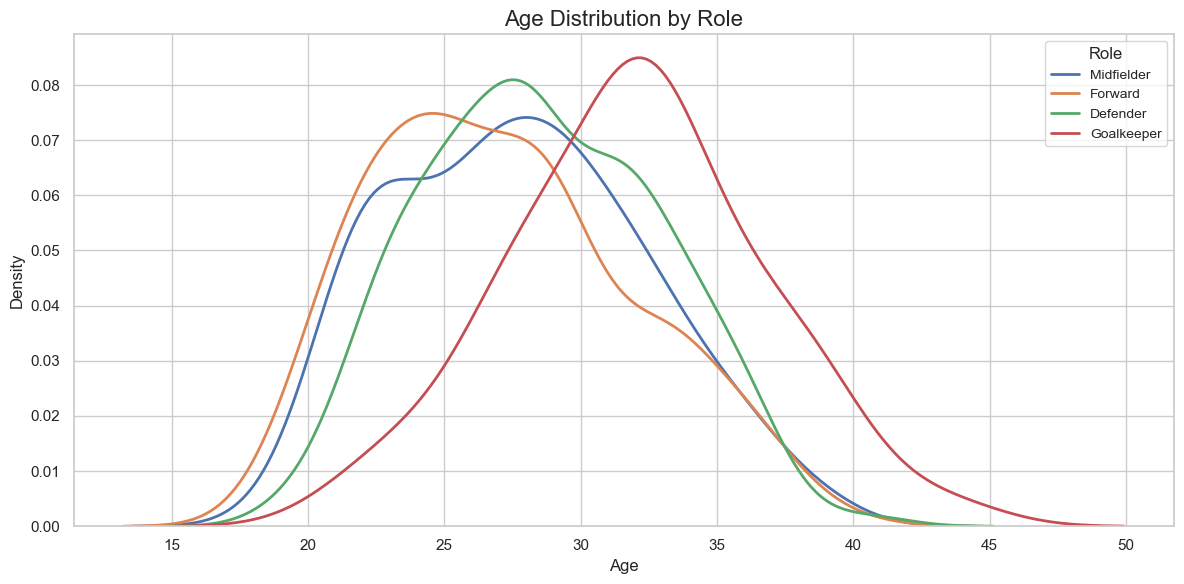

In [8]:
# Convert birth_date to datetime and calculate player age
df_players['birth_date'] = pd.to_datetime(df_players['birth_date'])
df_players['age'] = pd.Timestamp.now().year - df_players['birth_date'].dt.year

# Plot KDE with seaborn
plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")

# Overlay KDE for each role
for role in df_players['role'].unique():
    sns.kdeplot(
        data=df_players[df_players['role'] == role],
        x='age',
        label=role,
        fill=False,  # Set to True for filled KDE plots
        linewidth=2
    )

# Customize plot
plt.title("Age Distribution by Role", fontsize=16)
plt.xlabel("Age", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.legend(title="Role", fontsize=10)
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

Opazno je, da so vratarji starejši od igralcev na drugih pozicijah ter, da je njihov potek keriere ponavadi zamaknjen za nekaj let v primerjavi z ostalimi. Najmlajši so (po pričakovanjih) napadalno usmerjeni igralci.

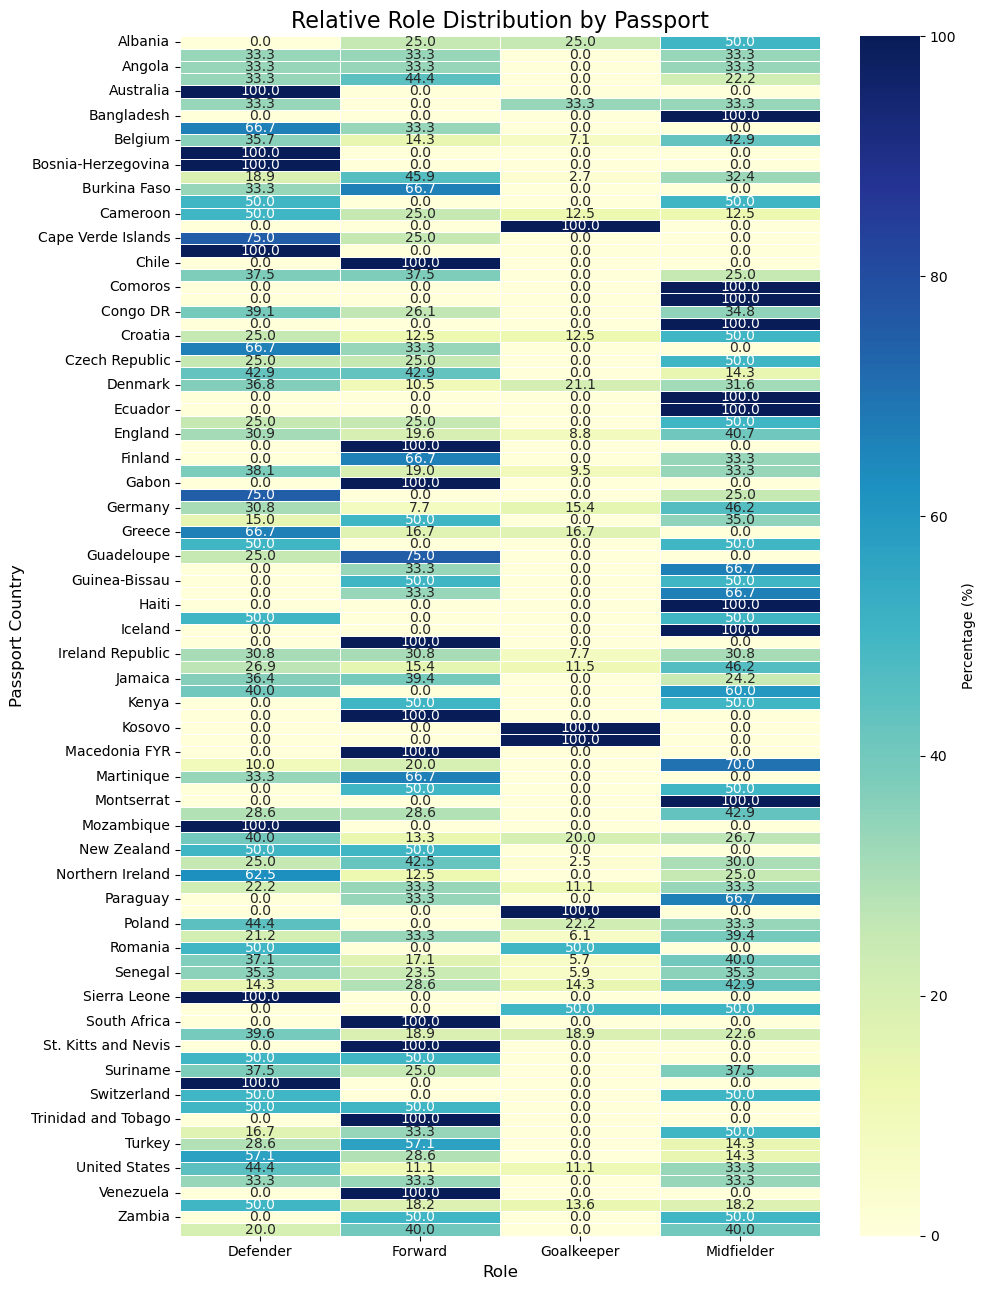

In [3]:
# Count players per role and passport
grouped = df_players.groupby(['passport', 'role']).size().unstack(fill_value=0)

# Calculate relative percentages
grouped_percentage = grouped.div(grouped.sum(axis=1), axis=0) * 100  # Normalize by row sum

# Plot heatmap for relative percentages
plt.figure(figsize=(10, 13))
sns.heatmap(
    grouped_percentage,
    annot=True,
    fmt=".1f",  # Display percentages with one decimal point
    cmap="YlGnBu",
    linewidths=0.5,
    cbar_kws={'label': 'Percentage (%)'}
)

# Customize the plot
plt.title("Relative Role Distribution by Passport", fontsize=16)
plt.xlabel("Role", fontsize=12)
plt.ylabel("Passport Country", fontsize=12)
plt.tight_layout()

# Show the plot
plt.show()

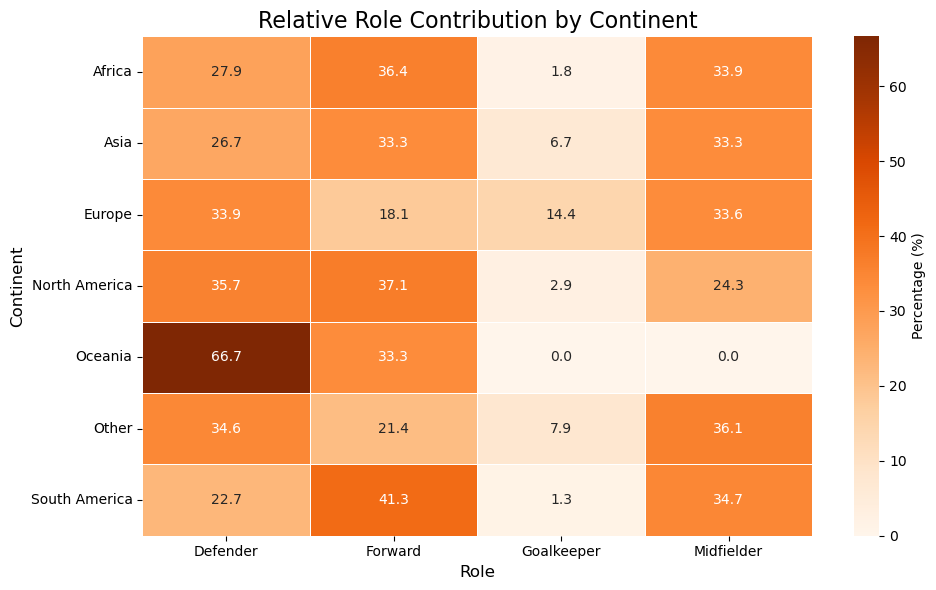

In [4]:
from pycountry_convert import country_alpha2_to_continent_code, country_name_to_country_alpha2

# Helper function to map countries to continents
def map_country_to_continent(country_name):
    try:
        country_code = country_name_to_country_alpha2(country_name)
        continent_code = country_alpha2_to_continent_code(country_code)
        continent_mapping = {
            'AF': 'Africa',
            'AS': 'Asia',
            'EU': 'Europe',
            'NA': 'North America',
            'SA': 'South America',
            'OC': 'Oceania',
        }
        return continent_mapping.get(continent_code, 'Other')
    except KeyError:
        return 'Other'

# Map countries to continents
df_players['continent'] = df_players['passport'].apply(map_country_to_continent)

# Group by continent and role, then count players
grouped = df_players.groupby(['continent', 'role']).size().unstack(fill_value=0)

# Normalize by row sum (relative contribution per continent)
grouped_percentage = grouped.div(grouped.sum(axis=1), axis=0) * 100  # Row-wise normalization

# Plot heatmap for relative percentages by continent
plt.figure(figsize=(10, 6))
sns.heatmap(
    grouped_percentage,
    annot=True,
    fmt=".1f",  # Display percentages with one decimal point
    cmap="Oranges",
    linewidths=0.5,
    cbar_kws={'label': 'Percentage (%)'}
)

# Customize the plot
plt.title("Relative Role Contribution by Continent", fontsize=16)
plt.xlabel("Role", fontsize=12)
plt.ylabel("Continent", fontsize=12)
plt.tight_layout()

# Show the plot
plt.show()

Lahko vidimo, da Evropa relativno prispeva najmanj napadalcev, medtem ko Afrika in Južna Amerika od vseh svojih igralcev prispevata največ napadalcev. Pravtako Evropa krepko prevladuje med vrataraji. Podatki za Oceanio niso relevantni, saj prispeva zelo malo igralcev (3).

In [6]:
# Absolute numbers of players by continent and role
absolute_numbers = grouped.copy()

absolute_numbers['Total Players'] = absolute_numbers.sum(axis=1)  # Add row totals
absolute_numbers.loc['Total Roles'] = absolute_numbers.sum(axis=0)  # Add column totals

# Display styled table
print("Absolute Number of Players by Continent and Role")
print(absolute_numbers)

Absolute Number of Players by Continent and Role
role           Defender  Forward  Goalkeeper  Midfielder  Total Players
continent                                                              
Africa               46       60           3          56            165
Asia                  4        5           1           5             15
Europe               92       49          39          91            271
North America        25       26           2          17             70
Oceania               2        1           0           0              3
Other               118       73          27         123            341
South America        17       31           1          26             75
Total Roles         304      245          73         318            940


### Players TM Values
Gre za podatke o igralcih iz **TransferMarkta**, kako se je gibal njihov market value.
* Player_id - id igralca - int64
* tm_player_id - id igralca na transfermarktu - int64
* date - datum evaluacije market value-a - datetime64[ns]
 * market_value - int64         
 * age - object  **AGE JE KOT OBJECT TO PAZI!!!**      
 * team_name - object        
 * short_name - ime igralca - object        
 * role - pozicija - object        
 *  __index_level_0__ - index, ki je isti kot avtomatski index - int64   

In [2]:
df_tm = duckdb.sql(f"""SELECT * FROM 'data/player_tm_values.parquet' """).df()
df_tm

player_id  tm_player_id                date  market_value age  \
0         763431        586834 2021-10-05 00:00:00        500000  19   
1         763431        586834 2023-04-05 00:00:00       1000000  20   
2         763431        586834 2023-10-09 00:00:00       2000000  21   
3         763431        586834 2023-12-19 00:00:00       2000000  21   
4         763431        586834 2024-05-27 00:00:00       2000000  21   
...          ...           ...                 ...           ...  ..   
19835     644804        743600 2024-06-02 22:00:00      15000000  20   
19836     644804        743600 2024-10-06 22:00:00      18000000  20   
19837     623588        681615 2024-03-13 23:00:00        200000  20   
19838     735725        747153 2023-10-08 22:00:00        600000  19   
19839     735725        747153 2023-12-18 23:00:00        900000  19   

                  team_name     short_name        role  __index_level_0__  
0        Crystal Palace U21   J. Rak-Sakyi     Forward                  0  
1         Charlton Athletic   J. Rak-Sakyi     Forward                  1  
2            Crystal Palace   J. Rak-Sakyi     Forward                  2  
3            Crystal Palace   J. Rak-Sakyi     Forward                  3  
4            Crystal Palace   J. Rak-Sakyi     Forward                  4  
...                     ...            ...         ...                ...  
19835  RC Strasbourg Alsace  Andrey Santos  Midfielder              19835  
19836  RC Strasbourg Alsace  Andrey Santos  Midfielder              19836  
19837        Chelsea FC U21  J. Tauriainen  Midfielder              19837  
19838     Manchester United        D. Gore  Midfielder              19838  
19839     Manchester United        D. Gore  Midfielder              19839  

[19840 rows x 9 columns]

In [16]:
df_tm.head(20)

player_id  tm_player_id       date  market_value age           team_name  \
0      763431        586834 2021-10-05        500000  19  Crystal Palace U21   
1      763431        586834 2023-04-05       1000000  20   Charlton Athletic   
2      763431        586834 2023-10-09       2000000  21      Crystal Palace   
3      763431        586834 2023-12-19       2000000  21      Crystal Palace   
4      763431        586834 2024-05-27       2000000  21      Crystal Palace   
5       21285         74943 2009-01-17        600000  21    AC Sparta Prague   
6       21285         74943 2009-03-17       1500000  22    AC Sparta Prague   
7       21285         74943 2010-07-19       2000000  23    AC Sparta Prague   
8       21285         74943 2010-10-24       2300000  23    AC Sparta Prague   
9       21285         74943 2011-01-10       4000000  23           Genoa CFC   
10      21285         74943 2011-06-21       5500000  24           Genoa CFC   
11      21285         74943 2012-01-11       5000000  24           Genoa CFC   
12      21285         74943 2012-06-08       4800000  25           Genoa CFC   
13      21285         74943 2013-01-14       5200000  25           Genoa CFC   
14      21285         74943 2013-06-19       7000000  26           Genoa CFC   
15      21285         74943 2014-01-07       6500000  26           Genoa CFC   
16      21285         74943 2014-07-01       6000000  27           Genoa CFC   
17      21285         74943 2015-01-07       6000000  27           Genoa CFC   
18      21285         74943 2015-07-01       6000000  28           Genoa CFC   
19      21285         74943 2016-01-04       6000000  28            AC Milan   

      short_name        role  __index_level_0__  
0   J. Rak-Sakyi     Forward                  0  
1   J. Rak-Sakyi     Forward                  1  
2   J. Rak-Sakyi     Forward                  2  
3   J. Rak-Sakyi     Forward                  3  
4   J. Rak-Sakyi     Forward                  4  
5       J. Kucka  Midfielder                  5  
6       J. Kucka  Midfielder                  6  
7       J. Kucka  Midfielder                  7  
8       J. Kucka  Midfielder                  8  
9       J. Kucka  Midfielder                  9  
10      J. Kucka  Midfielder                 10  
11      J. Kucka  Midfielder                 11  
12      J. Kucka  Midfielder                 12  
13      J. Kucka  Midfielder                 13  
14      J. Kucka  Midfielder                 14  
15      J. Kucka  Midfielder                 15  
16      J. Kucka  Midfielder                 16  
17      J. Kucka  Midfielder                 17  
18      J. Kucka  Midfielder                 18  
19      J. Kucka  Midfielder                 19

In [12]:
df_tm.shape

(19840, 9)

In [13]:
df_tm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19840 entries, 0 to 19839
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   player_id          19840 non-null  int64         
 1   tm_player_id       19840 non-null  int64         
 2   date               19840 non-null  datetime64[ns]
 3   market_value       19840 non-null  int64         
 4   age                19840 non-null  object        
 5   team_name          19840 non-null  object        
 6   short_name         19840 non-null  object        
 7   role               19840 non-null  object        
 8   __index_level_0__  19840 non-null  int64         
dtypes: datetime64[ns](1), int64(4), object(4)
memory usage: 1.4+ MB


In [15]:
df_tm.isnull().sum()

player_id            0
tm_player_id         0
date                 0
market_value         0
age                  0
team_name            0
short_name           0
role                 0
__index_level_0__    0
dtype: int64

#### Reševanje problema age(object)

In [9]:
# Check for unique values in the `age` column
print(df_tm['age'].unique())

['19' '20' '21' '22' '23' '24' '25' '26' '27' '28' '29' '30' '31' '32'
 '33' '34' '35' '36' '37' '18' '17' '16' '38' '39' '40' '41' '15']


In [11]:
# Alternatively, find rows where `age` is not numeric
non_numeric_ages = df_tm[~df_tm['age'].str.isnumeric()]
print(non_numeric_ages)

Empty DataFrame
Columns: [player_id, tm_player_id, date, market_value, age, team_name, short_name, role, __index_level_0__]
Index: []


In [14]:
# Convert the age column to numeric
df_tm['age'] = pd.to_numeric(df_tm['age'], errors='coerce')

# Verify that the conversion worked
print(df_tm['age'].unique()) 

[19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 18 17 16 38 39
 40 41 15]


#### VIZUALIZACIJE

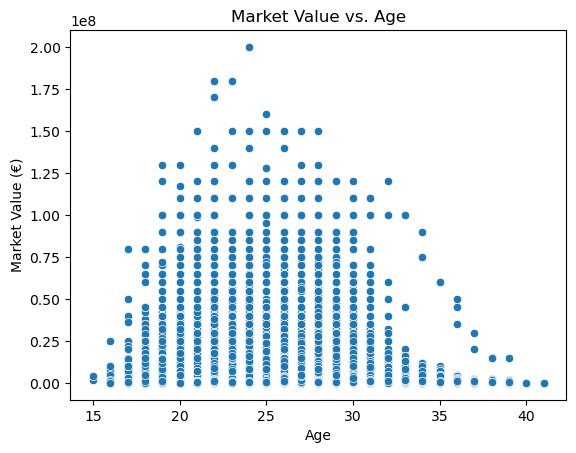

In [15]:
sns.scatterplot(data=df_tm, x='age', y='market_value')
plt.title("Market Value vs. Age")
plt.xlabel("Age")
plt.ylabel("Market Value (€)")
plt.show()

Opazimo, da se najvišje vrednosti igralcev, po večini pojavljajo med 20. in 28. letom, čisti vrh okoli 24

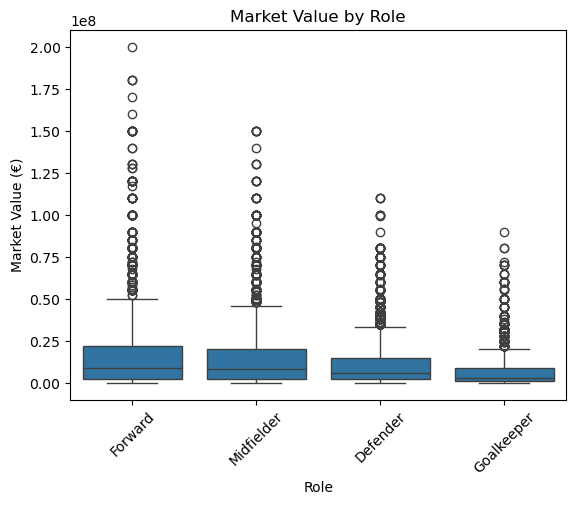

In [16]:
sns.boxplot(data=df_tm, x='role', y='market_value')
plt.title("Market Value by Role")
plt.xlabel("Role")
plt.ylabel("Market Value (€)")
plt.xticks(rotation=45)
plt.show()

Najdražji so napadalci, porazdelitev po vseh pozicijah pa je **občutno asinhrona** z velikim številom **osamelcev**.

In [18]:
# Sort the dataframe by market_value in descending order
top_10_expensive_players = df_tm.sort_values(by='market_value', ascending=False).head(10)

# Display the top 10 most expensive players
print(top_10_expensive_players[['short_name', 'team_name', 'role', 'market_value']])


          short_name          team_name     role  market_value
14578     E. Haaland    Manchester City  Forward     200000000
14577     E. Haaland    Manchester City  Forward     180000000
14576     E. Haaland    Manchester City  Forward     180000000
14575     E. Haaland    Manchester City  Forward     180000000
14574     E. Haaland    Manchester City  Forward     170000000
17800    R. Sterling    Manchester City  Forward     160000000
7263   Mohamed Salah       Liverpool FC  Forward     150000000
7050         H. Kane  Tottenham Hotspur  Forward     150000000
7266   Mohamed Salah       Liverpool FC  Forward     150000000
7265   Mohamed Salah       Liverpool FC  Forward     150000000


#### Team market value za vse data entry-je

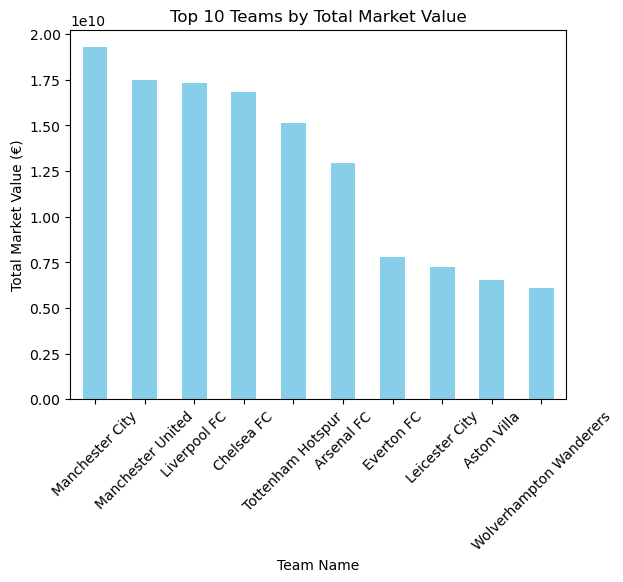

In [17]:
team_market_value = df_tm.groupby('team_name')['market_value'].sum().sort_values(ascending=False).head(10)
team_market_value.plot(kind='bar', color='skyblue')
plt.title("Top 10 Teams by Total Market Value")
plt.xlabel("Team Name")
plt.ylabel("Total Market Value (€)")
plt.xticks(rotation=45)
plt.show()

#### Zgolj latest market value

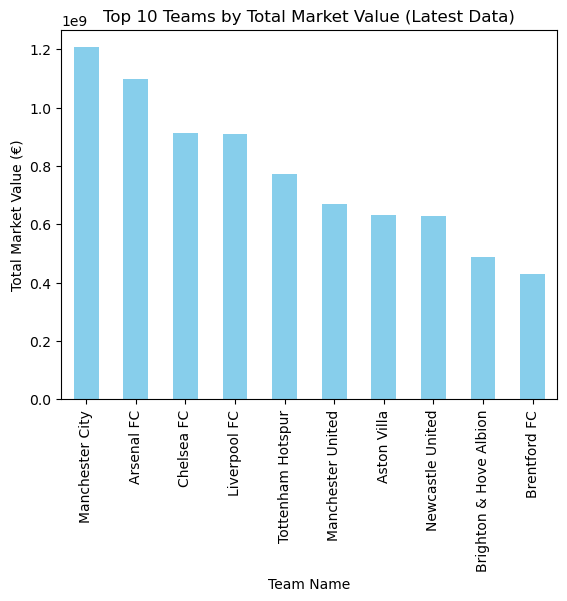

In [20]:
# Ensure 'date' is a datetime type
df_tm['date'] = pd.to_datetime(df_tm['date'])

# Get the latest entry for each player
latest_market_values = df_tm.sort_values(by=['player_id', 'date']).groupby('player_id').last()

# Group by team_name and calculate the total market value
team_market_value_latest = (
    latest_market_values.groupby('team_name')['market_value'].sum()
    .sort_values(ascending=False)
    .head(10)
)

# Plot the results
team_market_value_latest.plot(kind='bar', color='skyblue')
plt.title("Top 10 Teams by Total Market Value (Latest Data)")
plt.xlabel("Team Name")
plt.ylabel("Total Market Value (€)")
plt.xticks(rotation=90)
plt.show()


In [24]:
# Count the number of unique players based on the short_name column
unique_players_count = df_tm['player_id'].nunique()

# Display the count
print(f"Number of unique players: {unique_players_count}")

Number of unique players: 926


In [22]:
# Get unique player IDs from both dataframes
unique_ids_tm = set(df_tm['player_id'])
unique_ids_players = set(df_players['player_id'])

# Find the intersection of the two sets
common_ids = unique_ids_tm.intersection(unique_ids_players)

# Count the number of unique players in df_tm that are in df_players
common_count = len(common_ids)

# Display the result
print(f"Number of unique players in df_tm that are also in df_players: {common_count}")


Number of unique players in df_tm that are also in df_players: 926


In [23]:
# Verify if all player IDs in df_tm are also in df_players
all_in_players = unique_ids_tm.issubset(unique_ids_players)
print(f"Are all player IDs in df_tm present in df_players? {all_in_players}")

Are all player IDs in df_tm present in df_players? True


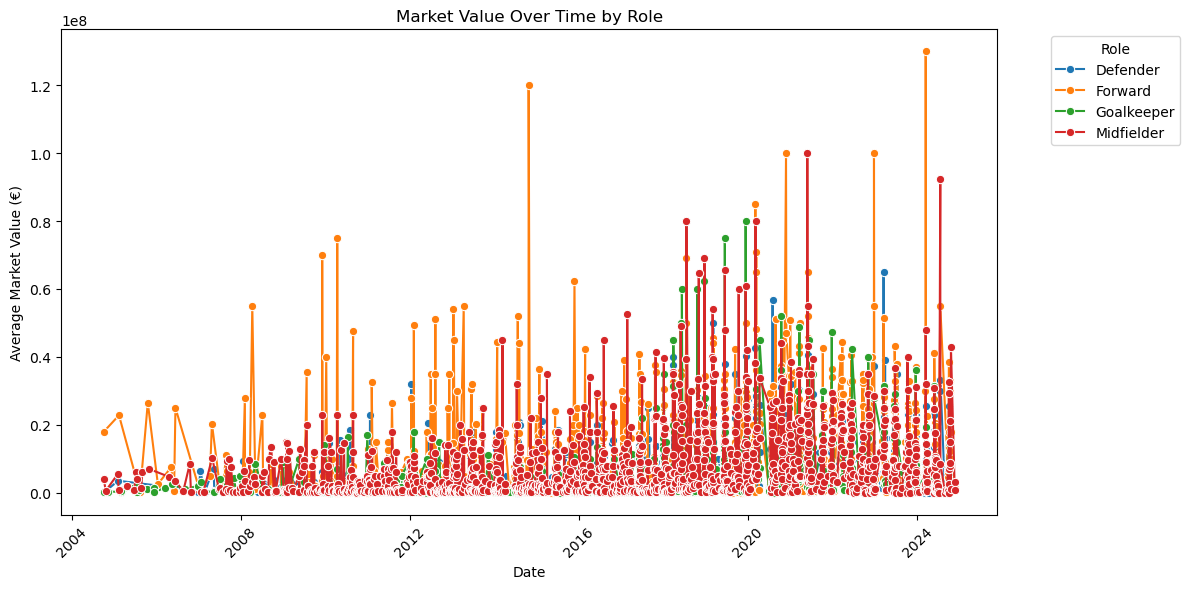

In [28]:
# Ensure 'date' is in datetime format
df_tm['date'] = pd.to_datetime(df_tm['date'])

# Group by role and date, then calculate the mean market value
market_value_by_role = df_tm.groupby(['role', 'date'])['market_value'].mean().reset_index()

# Plot the market value over time for each role
plt.figure(figsize=(12, 6))
sns.lineplot(data=market_value_by_role, x='date', y='market_value', hue='role', marker='o')
plt.title("Market Value Over Time by Role")
plt.xlabel("Date")
plt.ylabel("Average Market Value (€)")
plt.legend(title='Role', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


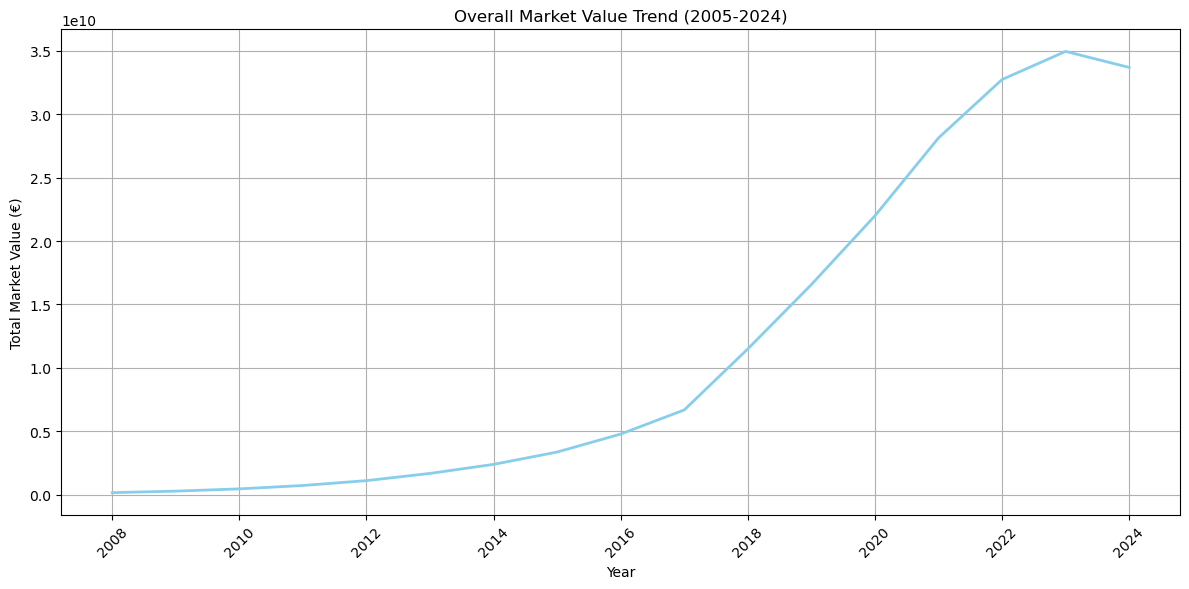

In [4]:
# Ensure 'date' is in datetime format and extract the year
df_tm['date'] = pd.to_datetime(df_tm['date'])
df_tm['year'] = df_tm['date'].dt.year

# Group by year and calculate total market value for each year
market_value_by_year = df_tm.groupby('year')['market_value'].sum()

# Smooth the curve using a rolling mean (you can adjust the window size)
market_value_smoothed = market_value_by_year.rolling(window=5).mean()  # Adjust the window for smoothness

# Plot the overall market value trend
plt.figure(figsize=(12, 6))
plt.plot(market_value_smoothed.index, market_value_smoothed, color='skyblue', lw=2)
plt.title("Overall Market Value Trend (2005-2024)")
plt.xlabel("Year")
plt.ylabel("Total Market Value (€)")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


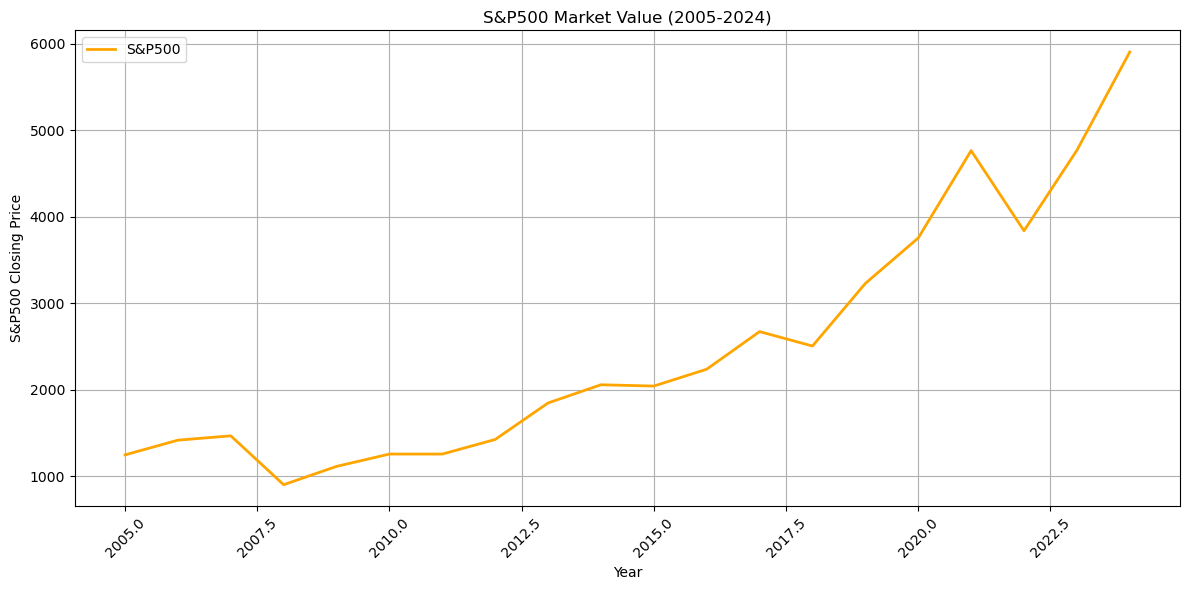

In [9]:
# Import necessary libraries
import yfinance as yf
import matplotlib.pyplot as plt

# Download S&P500 data from Yahoo Finance (2005-2024)
sp500 = yf.download('^GSPC', start='2005-01-01', end='2024-12-31', progress=False)

# Resample the S&P500 data to yearly frequency and use the closing price at year-end
sp500_yearly = sp500['Close'].resample('YE').last()

# Limit the S&P500 data to the last 20 years (2005-2024)
sp500_yearly = sp500_yearly[(sp500_yearly.index.year >= 2005) & (sp500_yearly.index.year <= 2024)]

# Plot S&P500 trend for the last 20 years
plt.figure(figsize=(12, 6))
plt.plot(sp500_yearly.index.year, sp500_yearly, color='orange', lw=2, label='S&P500')

# Adding labels and title
plt.title("S&P500 Market Value (2005-2024)")
plt.xlabel("Year")
plt.ylabel("S&P500 Closing Price")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

C:\Users\Uporabnik\AppData\Local\Temp\ipykernel_3796\424229958.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_10_players_per_role = latest_market_value.groupby('role').apply(lambda x: x.nlargest(10, 'market_value')).reset_index(drop=True)


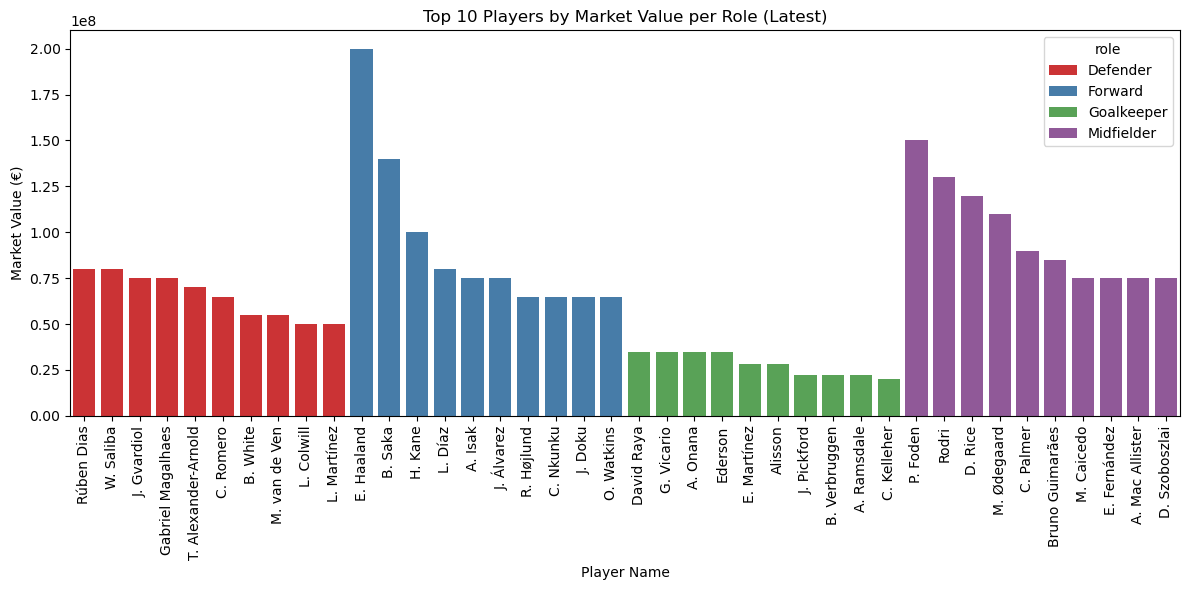

In [12]:
# Filter the dataframe to keep only the latest market value for each player
df_tm['date'] = pd.to_datetime(df_tm['date'])  # Ensure date is in datetime format
latest_market_value = df_tm.sort_values('date').drop_duplicates('player_id', keep='last')

# Sort and get the top 10 players by market value for each role
top_10_players_per_role = latest_market_value.groupby('role').apply(lambda x: x.nlargest(10, 'market_value')).reset_index(drop=True)

# Plot the top 10 players by market value per role
plt.figure(figsize=(12, 6))
sns.barplot(data=top_10_players_per_role, x='short_name', y='market_value', hue='role', dodge=False, palette='Set1')
plt.title("Top 10 Players by Market Value per Role (Latest)")
plt.xlabel("Player Name")
plt.ylabel("Market Value (€)")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

### Teams
Dataframe 25 premierligaskih ekip (team_id, name, country-england)

In [37]:
df_teams = duckdb.sql(f"""SELECT * FROM 'data/teams.parquet' """).df()
df_teams

team_id                     name  country  __index_level_0__
0      1636         Sheffield United  England                  0
1      1644                  Watford  England                  1
2      1660               Luton Town  England                  2
3      1613         Newcastle United  England                  3
4      1616                   Fulham  England                  4
5      1623                  Everton  England                  5
6      1628           Crystal Palace  England                  6
7      1651                 Brighton  England                  7
8      1619              Southampton  England                  8
9      1633          West Ham United  England                  9
10     1659              Bournemouth  England                 10
11     1612                Liverpool  England                 11
12     1625          Manchester City  England                 12
13     1646                  Burnley  England                 13
14     1631           Leicester City  England                 14
15     1669                Brentford  England                 15
16     1629  Wolverhampton Wanderers  England                 16
17     1630             Leeds United  England                 17
18     1642        Nottingham Forest  England                 18
19     1610                  Chelsea  England                 19
20     1609                  Arsenal  England                 20
21     1614              Aston Villa  England                 21
22     1624        Tottenham Hotspur  England                 22
23     1626             Norwich City  England                 23
24     1611        Manchester United  England                 24

In [18]:
df_teams.shape

(25, 4)

### Matches
Dataframe 1140 premierligaških tekem iz zadnjih let **(2021, 2022, 2023)**:
* match_id - int64 
* competition_id - zgolj premierleague - int64 
* date - object
* label - nasprotnika in rezultat - object
* gameweek - int64 
* home_team_id - navezuje na df_teams-  int64 
* away_team_id - -||- - int64 
* home_team_name - object
* away_team_name - object
* home_team_score - goli domace ekipe - int64 
* away_team_score - goli gostujoče ekipe -  int64 
* status - vedno "played" -  object
* home_coach_id - int64 
* away_coach_id - int64 
* season - int64 
* competition - vedno premierleague - int64 
* __index_level_0__  1140 non-null   int64 

In [14]:
df_matches = duckdb.sql(f"""SELECT * FROM 'data/matches.parquet' """).df()
df_matches

match_id  competition_id                 date  \
0      5235110             364  2022-04-02 14:00:00   
1      5235004             364  2022-03-17 19:45:00   
2      5234975             364  2021-12-14 19:45:00   
3      5234883             364  2021-10-17 13:00:00   
4      5234862             364  2021-09-25 11:30:00   
...        ...             ...                  ...   
1135   5464933             364  2023-08-26 16:00:00   
1136   5465291             364  2024-05-19 17:00:00   
1137   5465107             364  2023-12-30 16:00:00   
1138   5465006             364  2023-10-28 13:30:00   
1139   5464940             364  2023-08-27 17:30:00   

                                          label  gameweek  home_team_id  \
0                Brighton - Norwich City, 0 - 0        31          1651   
1             Everton - Newcastle United, 1 - 0        20          1623   
2             Norwich City - Aston Villa, 0 - 2        17          1626   
3              Everton - West Ham United, 0 - 1         8          1623   
4              Chelsea - Manchester City, 0 - 1         6          1610   
...                                         ...       ...           ...   
1135                      Arsenal - Fulham, 2-2         3          1609   
1136  Sheffield United - Tottenham Hotspur, 0-3        38          1636   
1137    Manchester City - Sheffield United, 2-0        20          1625   
1138                   Chelsea - Brentford, 0-2        10          1610   
1139          Newcastle United - Liverpool, 1-2         3          1613   

      away_team_id    home_team_name     away_team_name  home_team_score  \
0             1626          Brighton       Norwich City                0   
1             1613           Everton   Newcastle United                1   
2             1614      Norwich City        Aston Villa                0   
3             1633           Everton    West Ham United                0   
4             1625           Chelsea    Manchester City                0   
...            ...               ...                ...              ...   
1135          1616           Arsenal             Fulham                2   
1136          1624  Sheffield United  Tottenham Hotspur                0   
1137          1636   Manchester City   Sheffield United                2   
1138          1669           Chelsea          Brentford                0   
1139          1612  Newcastle United          Liverpool                1   

      away_team_score  status  home_coach_id  away_coach_id  season  \
0                   0  Played          51607           9128    2021   
1                   0  Played         569622           8934    2021   
2                   2  Played           9128         669699    2021   
3                   1  Played         210700           8235    2021   
4                   1  Played          15174         267136    2021   
...               ...     ...            ...            ...     ...   
1135                2  Played         743345          71037    2023   
1136                3  Played           9868          61546    2023   
1137                0  Played         267136           9868    2023   
1138                2  Played         292863         135095    2023   
1139                2  Played           8934          14791    2023   

      competition  __index_level_0__  
0             364                  0  
1             364                  1  
2             364                  2  
3             364                  3  
4             364                  4  
...           ...                ...  
1135          364               1135  
1136          364               1136  
1137          364               1137  
1138          364               1138  
1139          364               1139  

[1140 rows x 17 columns]

In [20]:
df_matches.shape

(1140, 17)

In [21]:
df_matches.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1140 entries, 0 to 1139
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   match_id           1140 non-null   int64 
 1   competition_id     1140 non-null   int64 
 2   date               1140 non-null   object
 3   label              1140 non-null   object
 4   gameweek           1140 non-null   int64 
 5   home_team_id       1140 non-null   int64 
 6   away_team_id       1140 non-null   int64 
 7   home_team_name     1140 non-null   object
 8   away_team_name     1140 non-null   object
 9   home_team_score    1140 non-null   int64 
 10  away_team_score    1140 non-null   int64 
 11  status             1140 non-null   object
 12  home_coach_id      1140 non-null   int64 
 13  away_coach_id      1140 non-null   int64 
 14  season             1140 non-null   int64 
 15  competition        1140 non-null   int64 
 16  __index_level_0__  1140 non-null   int64 


In [24]:
df_matches['competition_id'].value_counts()

competition_id
364    1140
Name: count, dtype: int64

In [26]:
df_matches['status'].value_counts()

status
Played    1140
Name: count, dtype: int64

In [25]:
df_matches.isnull().sum()

match_id             0
competition_id       0
date                 0
label                0
gameweek             0
home_team_id         0
away_team_id         0
home_team_name       0
away_team_name       0
home_team_score      0
away_team_score      0
status               0
home_coach_id        0
away_coach_id        0
season               0
competition          0
__index_level_0__    0
dtype: int64

In [37]:
df_matches['season'].value_counts()

season
2021    380
2022    380
2023    380
Name: count, dtype: int64

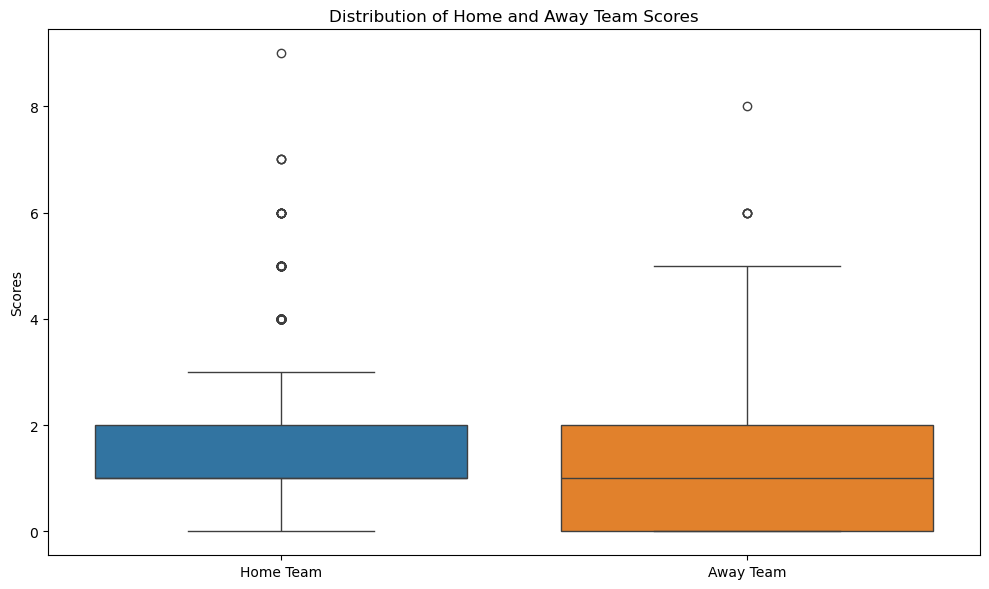

In [15]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_matches[['home_team_score', 'away_team_score']])
plt.title("Distribution of Home and Away Team Scores")
plt.ylabel("Scores")
plt.xticks([0, 1], ['Home Team', 'Away Team'])
plt.tight_layout()
plt.show()

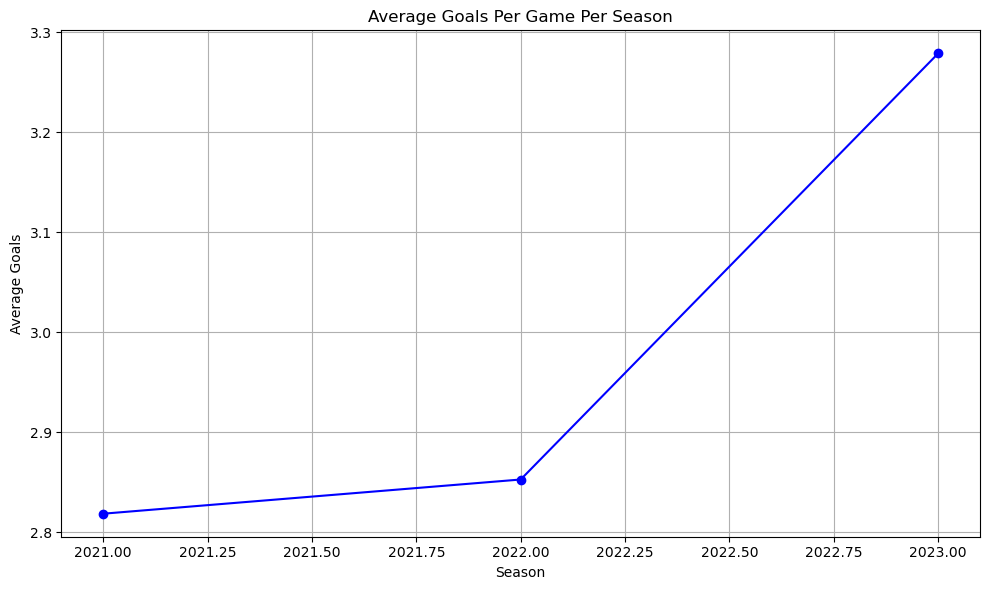

In [16]:
# Group by season and calculate average goals scored for both home and away teams
df_matches['total_goals'] = df_matches['home_team_score'] + df_matches['away_team_score']
avg_goals_per_season = df_matches.groupby('season')['total_goals'].mean()

plt.figure(figsize=(10, 6))
plt.plot(avg_goals_per_season.index, avg_goals_per_season.values, marker='o', color='b')
plt.title("Average Goals Per Game Per Season")
plt.xlabel("Season")
plt.ylabel("Average Goals")
plt.grid(True)
plt.tight_layout()
plt.show()

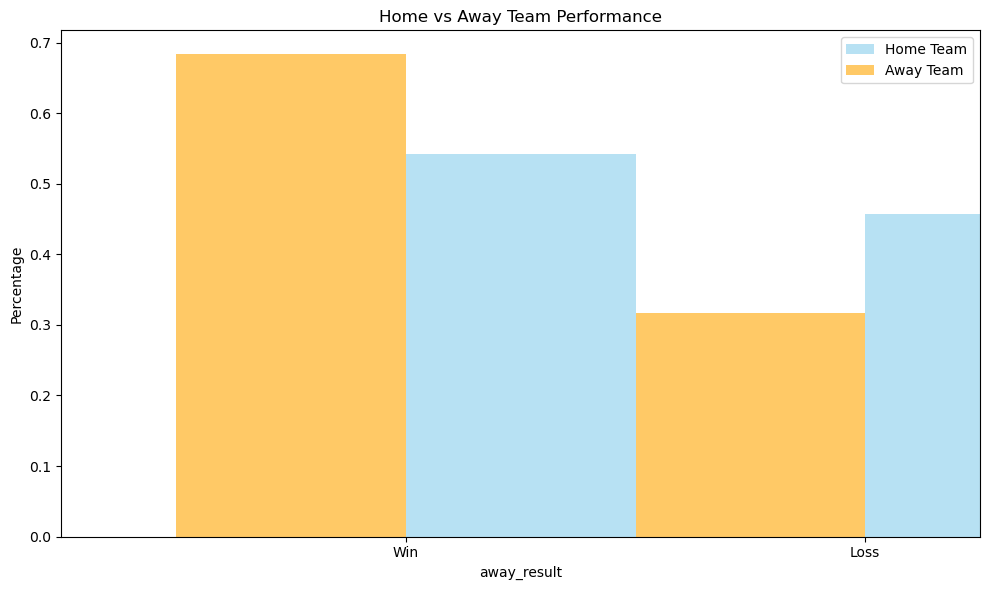

In [17]:
# Create win/loss/draw labels
df_matches['home_result'] = df_matches['home_team_score'] > df_matches['away_team_score']
df_matches['away_result'] = df_matches['away_team_score'] > df_matches['home_team_score']

home_performance = df_matches['home_result'].value_counts(normalize=True)
away_performance = df_matches['away_result'].value_counts(normalize=True)

# Plot home vs away win/loss
fig, ax = plt.subplots(figsize=(10, 6))
home_performance.plot(kind='bar', alpha=0.6, color='skyblue', label='Home Team', position=0, ax=ax)
away_performance.plot(kind='bar', alpha=0.6, color='orange', label='Away Team', position=1, ax=ax)

plt.title("Home vs Away Team Performance")
plt.ylabel("Percentage")
plt.xticks([0, 1], ['Win', 'Loss'], rotation=0)
plt.legend()
plt.tight_layout()
plt.show()


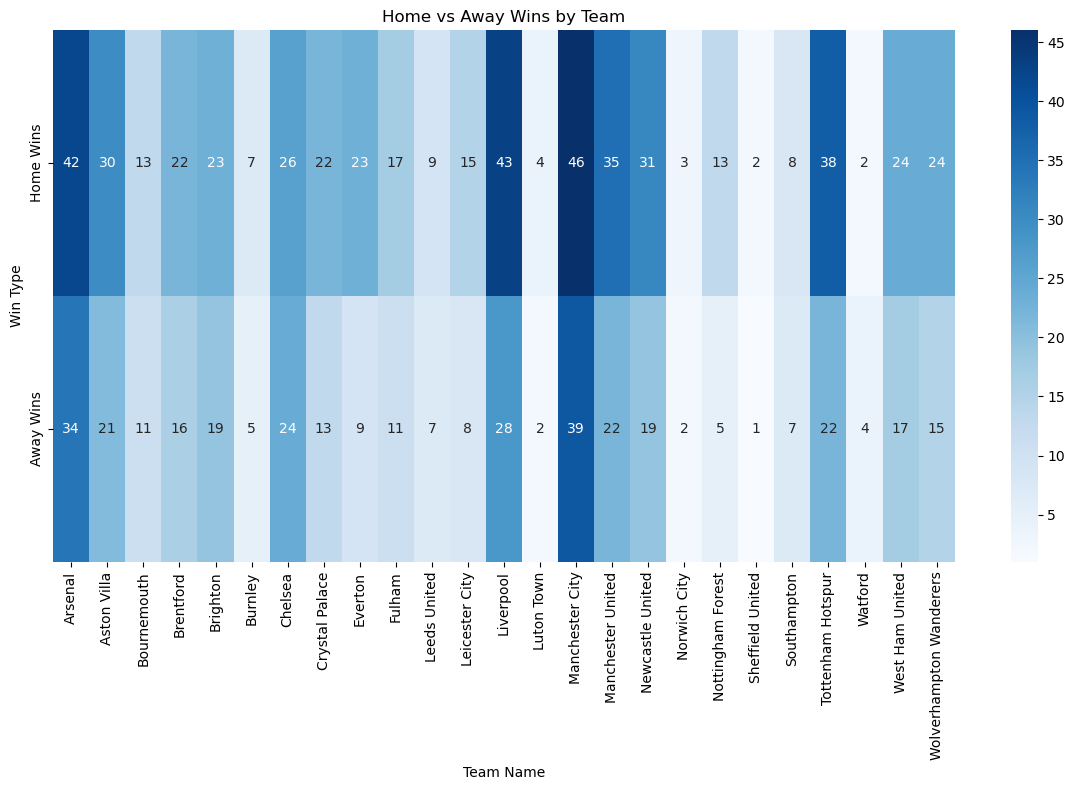

In [19]:
# Count the number of home and away wins
home_wins = df_matches[df_matches['home_result'] == True].groupby('home_team_name').size()
away_wins = df_matches[df_matches['away_result'] == True].groupby('away_team_name').size()

# Combine the two series
performance = pd.DataFrame({
    'Home Wins': home_wins,
    'Away Wins': away_wins
}).fillna(0)

# Plot a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(performance.T, annot=True, cmap='Blues', fmt='.0f')
plt.title("Home vs Away Wins by Team")
plt.ylabel("Win Type")
plt.xlabel("Team Name")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

### Stories
Gre za dataframe **DOGODKOV**, ki so se odvijali na tekmah - okarakterizirani kot bool (true pomeni, da se je ta dogodek zgodil).
Preko drugih dataframe-ov je povezan z **id atributi**:
* 'player_id'
* 'team_id'
* 'shot_against_gkid'
* 'possession_team_id'
* 'duel_opponent_id'
* 'pass_recipient_id'

Torej uporablja naslednje dataframes-e:
* teams
* players

### Brisnanje vrstic, kjer je kakšen podatek -1 ni pametno, ker gre za akcijo oz. dogodek, kjer ta podatek ni applicable (preveri se za 0, in nekatere vrednosti, s katerimi ni bilo ujemanja v df_players)

In [3]:
df_stories = duckdb.sql(f"""SELECT * FROM 'data/stories.parquet' """).df()
df_stories

player_position  throw_in  start_x  penalty_conceded_goal  \
0                   AMF     False       49                  False   
1                    CF     False       27                  False   
2                  LCMF     False       36                  False   
3                   RCB     False       57                  False   
4                   AMF     False       67                  False   
...                 ...       ...      ...                    ...   
1946300             AMF     False       81                  False   
1946301            None     False        0                  False   
1946302              GK     False        0                  False   
1946303            LAMF     False       24                  False   
1946304              GK     False        5                  False   

         penalty_foul  lateral_pass  own_goal  linkup_play               type  \
0               False         False     False        False               pass   
1               False         False     False        False               pass   
2               False         False     False        False       interception   
3               False         False     False        False               pass   
4               False         False     False        False               pass   
...               ...           ...       ...          ...                ...   
1946300         False         False     False        False               shot   
1946301         False         False     False        False  game_interruption   
1946302         False         False     False        False          goal_kick   
1946303         False          True     False        False               pass   
1946304         False         False     False        False               pass   

         red_card  ...  shot_goal_zone  conceded_goal  is_pass  \
0           False  ...            None          False     True   
1           False  ...            None          False     True   
2           False  ...            None          False     True   
3           False  ...            None          False     True   
4           False  ...            None          False     True   
...           ...  ...             ...            ...      ...   
1946300     False  ...             otr          False    False   
1946301     False  ...            None          False    False   
1946302     False  ...            None          False     True   
1946303     False  ...            None          False     True   
1946304     False  ...            None          False     True   

         possession_attack  pass_blocked  opportunity  possession_id  shot_id  \
0                     True         False        False     1296149340        0   
1                     True         False        False     1296149340        0   
2                     True         False        False     1296149340        0   
3                     True         False        False     1296149340        0   
4                     True         False        False     1296149340        0   
...                    ...           ...          ...            ...      ...   
1946300               True         False        False     1854589816        0   
1946301              False         False        False             -1        0   
1946302              False         False        False     1854589775        0   
1946303              False         False        False     1854589775        0   
1946304              False         False        False     1854589775        0   

         possession_set_piece_attack  __index_level_0__  
0                              False                  0  
1                              False                  1  
2                              False                  2  
3                              False                  3  
4                              False                  4  
...                              ...                ...  
1946300                        Fal

In [4]:
# Filter and print column names that contain "id"
assist_columns = [col for col in df_stories.columns if "assist" in col.lower()]
print(assist_columns)

['assist', 'shot_assist', 'third_assist', 'second_assist']


In [6]:
df_stories.value_counts('type')

type
pass                 968435
duel                 470156
touch                139383
interception          94640
game_interruption     75443
throw_in              42627
free_kick             27878
shot                  26460
infraction            25460
goal_kick             16670
acceleration          14922
clearance             13126
corner                11890
shot_against          10608
offside                3924
goalkeeper_exit        3557
fairplay                688
penalty                 309
own_goal                129
Name: count, dtype: int64

In [5]:
df_stories.value_counts('player_position')

player_position
RB       148822
LB       148527
LCB      146383
RCB      144505
CF       125995
GK        98809
DMF       75197
AMF       73077
LCMF      71507
RCMF      70821
LCMF3     55633
RCMF3     54465
LDMF      53871
RDMF      52141
RW        48033
LW        47958
LAMF      46051
RAMF      45672
LCB3      42763
RCB3      42611
RWF       41372
LWF       41325
CB        40777
SS        33254
RWB       28355
LWB       26982
LB5       12425
RB5       12345
Name: count, dtype: int64

In [38]:
df_stories.to_csv("stories.csv", index=False)

In [28]:
df_stories.shape

(1946305, 138)

In [29]:
df_stories.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1946305 entries, 0 to 1946304
Columns: 138 entries, player_position to __index_level_0__
dtypes: bool(107), float32(5), int64(22), object(4)
memory usage: 621.8+ MB


In [30]:
df_stories.isnull().sum()

player_position                116629
throw_in                            0
start_x                             0
penalty_conceded_goal               0
penalty_foul                        0
                                ...  
opportunity                         0
possession_id                       0
shot_id                             0
possession_set_piece_attack         0
__index_level_0__                   0
Length: 138, dtype: int64

In [40]:
stories_columns = df_stories.columns.tolist()
stories_columns

['player_position',
 'throw_in',
 'start_x',
 'penalty_conceded_goal',
 'penalty_foul',
 'lateral_pass',
 'own_goal',
 'linkup_play',
 'type',
 'red_card',
 'penalty_goal',
 'kept_possession',
 'xA',
 'possession_free_kick',
 'shot_after_corner',
 'hand_pass',
 'key_pass',
 'game_interruption',
 'head_pass',
 'head_shot',
 'save_with_reflex',
 'assist',
 'goal_kick',
 'shot_assist',
 'own_goal_for',
 'successful',
 'through_pass',
 'offensive_duel',
 'start_y',
 'third_assist',
 'recovery',
 'pass_length',
 'corner',
 'fairplay',
 'aerial_won',
 'possession_transition_low',
 'possession_duration',
 'possession_transition_medium',
 'season',
 'clearance',
 'progressive_pass',
 'free_kick_shot',
 'pass_to_final_third',
 'interception',
 'shot_off_target',
 'acceleration',
 'shot_xgot',
 'short_or_medium_pass',
 'match_state',
 'free_kick',
 'free_kick_cross',
 'duel',
 'take_on',
 'penalty',
 'aerial_duel',
 'foul_suffered',
 'dribble',
 'shot_block',
 'shot_body_part',
 'stopped_progres

In [42]:
# Filter and print column names that contain "id"
id_columns = [col for col in df_stories.columns if "id" in col.lower()]
print(id_columns)

['sliding_tackle', 'player_id', 'id', 'team_id', 'offside', 'shot_against_gkid', 'possession_team_id', 'duel_opponent_id', 'pass_recipient_id', 'possession_id', 'shot_id']


#### PREVERJANJE UJEMANJA MED DATAFRAME-i

#### Players

In [23]:
# Get unique player IDs from df_stories
unique_player_ids = df_stories['player_id'].unique()

# Check if these player IDs are in df_players
missing_players = [player_id for player_id in unique_player_ids if player_id not in df_players['player_id'].values]

# Display the result
if missing_players:
    print(f"Missing player IDs in df_players: {missing_players}")
else:
    print("All player IDs from df_stories are present in df_players.")

Missing player IDs in df_players: [0, 886705, 776484, 1049953]


In [24]:
# Get unique shot_against_gkid values from df_stories
unique_shot_against_gkid = df_stories['shot_against_gkid'].unique()

# Check if these shot IDs are in df_players
missing_shot_ids = [shot_id for shot_id in unique_shot_against_gkid if shot_id not in df_players['player_id'].values]

# Display the result
if missing_shot_ids:
    print(f"Missing shot IDs in df_players: {missing_shot_ids}")
else:
    print("All shot IDs from df_stories are present in df_players.")

Missing shot IDs in df_players: [-1]


In [25]:
# Get unique duel_opponent_id values from df_stories
unique_duel_opponent_ids = df_stories['duel_opponent_id'].unique()

# Check if these opponent IDs are in df_players
missing_duel_opponents = [duel_opponent for duel_opponent in unique_duel_opponent_ids if duel_opponent not in df_players['player_id'].values]

# Display the result
if missing_duel_opponents:
    print(f"Missing duel opponent IDs in df_players: {missing_duel_opponents}")
else:
    print("All duel opponent IDs from df_stories are present in df_players.")

Missing duel opponent IDs in df_players: [-1, 0, 886705, 776484, 1049953]


In [26]:
# Get unique pass_recipient_id values from df_stories
unique_pass_recipient_ids = df_stories['pass_recipient_id'].unique()

# Check if these pass recipient IDs are in df_players
missing_pass_recipients = [recipient_id for recipient_id in unique_pass_recipient_ids if recipient_id not in df_players['player_id'].values]

# Display the result
if missing_pass_recipients:
    print(f"Missing pass recipient IDs in df_players: {missing_pass_recipients}")
else:
    print("All pass recipient IDs from df_stories are present in df_players.")

Missing pass recipient IDs in df_players: [-1, 0, 886705, 776484, 1049953]


In [32]:
top_list = duckdb.sql(f"""
    SELECT player_id,
    FROM 'data/stories.parquet' 
    WHERE player_id = 886705 OR player_id = 776484 OR player_id = 1049953 OR player_id = 0 OR player_id = -1
""").df()

top_list

player_id
0               0
1               0
2               0
3               0
4               0
...           ...
116735          0
116736          0
116737          0
116738          0
116739          0

[116740 rows x 1 columns]

**Brisanje vrstic kjer je igralec ali ekipa -1 mogoce ni pametno, ker bi to lahko pomenlo, da žoga ni v posesti od nobenega, ali kaj podobnega, kaki event ki ni povezan s posestjo!!!**

### Minutes
Dataframe, ki pove koliko minut je določen igralec igral na določeni tekmi v premier ligi. Povezuje se z dataframe-i:
* matches (match_id)
* players (player_id)
* teams (team_id)

In [31]:
df_minutes = duckdb.sql(f"""SELECT * FROM 'data/minutes.parquet' """).df()
df_minutes

match_id  player_id  team_id          position  minutes_played  \
0       5235180      49876     1609        Midfielder              63   
1       5235180     346158     1609           Striker              67   
2       5235180     520291     1609            Winger              78   
3       5235180     433506     1609        Goalkeeper              90   
4       5235180      70389     1609         Full Back              90   
...         ...        ...      ...               ...             ...   
33198   5465034      71703     1611  Central Defender              90   
33199   5465034     601883     1611            Winger              24   
33200   5465034     285590     1611        Midfielder              24   
33201   5465034     486252     1611         Full Back              20   
33202   5465034     584761     1611            Winger              11   

       competition  season  __index_level_0__  
0              364    2021                  0  
1              364    2021                  1  
2              364    2021                  2  
3              364    2021                  3  
4              364    2021                  4  
...            ...     ...                ...  
33198          364    2023              33198  
33199          364    2023              33199  
33200          364    2023              33200  
33201          364    2023              33201  
33202          364    2023              33202  

[33203 rows x 8 columns]

In [32]:
df_minutes.shape

(33203, 8)

In [33]:
df_minutes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33203 entries, 0 to 33202
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   match_id           33203 non-null  int64 
 1   player_id          33203 non-null  int64 
 2   team_id            33203 non-null  int64 
 3   position           33203 non-null  object
 4   minutes_played     33203 non-null  int32 
 5   competition        33203 non-null  int64 
 6   season             33203 non-null  int64 
 7   __index_level_0__  33203 non-null  int64 
dtypes: int32(1), int64(6), object(1)
memory usage: 1.9+ MB


In [34]:
df_minutes.describe()

match_id     player_id       team_id  minutes_played  competition  \
count  3.320300e+04  3.320300e+04  33203.000000    33203.000000      33203.0   
mean   5.354780e+06  2.835584e+05   1628.493630       69.333885        364.0   
std    9.326902e+04  2.075686e+05     16.786218       28.676997          0.0   
min    5.234810e+06  4.700000e+01   1609.000000        0.000000        364.0   
25%    5.235111e+06  4.078700e+04   1613.000000       48.000000        364.0   
50%    5.354678e+06  2.936860e+05   1625.000000       90.000000        364.0   
75%    5.465014e+06  4.474240e+05   1636.000000       90.000000        364.0   
max    5.465291e+06  1.049953e+06   1669.000000       90.000000        364.0   

             season  __index_level_0__  
count  33203.000000        33203.00000  
mean    2022.027407        16601.00000  
std        0.810915         9585.02483  
min     2021.000000            0.00000  
25%     2021.000000         8300.50000  
50%     2022.000000        16601.00000  
75%     2023.000000        24901.50000  
max     2023.000000        33202.00000

In [35]:
df_minutes.isnull().sum()

match_id             0
player_id            0
team_id              0
position             0
minutes_played       0
competition          0
season               0
__index_level_0__    0
dtype: int64

In [36]:
df_minutes['season'].value_counts()

season
2023    11384
2022    11345
2021    10474
Name: count, dtype: int64

# Novi stories

In [7]:
df_stories = duckdb.sql(f"""SELECT * FROM 'data/stories_updated.parquet' """).df()

In [8]:
# Filter and print column names that contain "id"
id_columns = [col for col in df_stories.columns if "id" in col.lower()]
print(id_columns)

['player_id', 'shot_against_gkid', 'id', 'match_id', 'pass_recipient_id', 'team_id', 'possession_team_id', 'offside', 'sliding_tackle', 'duel_opponent_id', 'possession_id', 'shot_id']
